In [169]:
#In order to access the database from google drive, we first have to mount our drive to google
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#importing confusion matrix 
from sklearn.metrics import confusion_matrix



# Suicide Detection Project EDA
This is Abdulaziz AlHothi's project of building a machine learning model that can improve suicide detection through lingual indications on social media. The [dataset](https://https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch) (specifically Cleaned Suicidewatch Vs. Depression) imported into this project draws texts from SuicideWatch reports and depression forums , classing them into two different classes "SuicideWatch" and "Depression".


## Note 0: Improving dataset selection
Earlier feedback to this project was that it looks at a dataset that compares text from r/suicide, to texts from r/depression and r/teenagers. 

However, to improve the scope of this project, I will be using an alternative e dataset (from the same source) which compares posts marked for suicidewatch (directly looking at very high risk of suicide ideation) and posts from r/depression. The goal is to create a machine learning model that can differentiate between generic posts on r/depression and suicidewatch listed texts from r/suicide. 

The overarching goal is of course for this project to act as a first step in building a more versatile machine learning model that is able to dileate text that is highly indicative of suicide ideation from text that is experessing depression.  

#### Limitations 

Separating suicidewatch from depression is, at a conceptual level, difficult. Theoretically, depression is a primary cause of suicide ([World Health Organization, 2014](https://www.who.int/publications/i/item/9789241564779)), so any text that expresses depression, is theoretically indicative of suicide. 

In practical terms, A lot of overlap between the two classes is to be expected. The goal is of course to achieve as much accurate separation as possible. 

Another limitation lies in the internal/construct validity of the research proposal. While we are aiming to dileneate suicide-ideation text from depression-text, we have to address that the content of the r/depression is not strictly all expressive of depression. A lot of posts and comments will express support, recovery and improvement in mood. While this is a limitation that is difficult to overcome within this project a lone, the unsupervised portion of this project will serve as an exploratory assessment to uncover what are the salient topics in both classes, and identify which topics are overlap, which topics describe their respective classes accurately, and which topics can be good separators of the classes. 


## EDA pipeline plan (initially...):
Here's the plan for this project's EDA (keep in mind that I will take iterative steps in case certain oddities come up -e.g step 9, 9a,9b..etc-
Step 1 – Data peek
Load the CSV and show a few rows.
 >> *answers “What does your data look like?”*

Step 2 – Train / val / test split
Print total sample size and create a 70 / 10 / 20 split.
>> answers “What’s the data size? How do you split the sets?”

Step 3 – Class‑balance check
Plot and print class proportions.
 >> *answers “What is the distribution of the target variable?”*

Step 4 – Pre‑processing & feature engineering
Compute text‑length stats, winsorize outliers, drop 30+‑char gibberish, build clean_text.
 >> *answers “What data‑cleaning / outlier handling steps do you perform?”*

Step 5 – Feature‑space description
Create TF‑IDF (5 000 dims) plus three numeric length features; print how many features and of what type.
 >> *answers “What’s your feature space? How many & what kinds of features?”*

Step 6 – Token‑level exploration
Show top n‑grams per class after stop‑word and noise filtering.
 >> *should somewhat address the guideline question “What words dominate each class?”*

Step 7 – Topic modelling
Run NMF topics on the cleaned corpus and print top words per topic.
>> *answers “What latent themes emerge in the posts?”*

Step 8 – 2‑D visualisation
Project TF‑IDF down to two SVD components and scatter‑plot by class.
>> *answers “Can we visualise class separation?”*

Step 9 – Numeric‑feature correlation
Heat‑map correlations; drop the redundant word_count_cap.
 >> *answers “Are any numeric features redundant?”*

Step 10 – Baseline classifier
Train TF‑IDF + numeric logistic regression; report accuracy, per‑class precision/recall/F1, ROC‑AUC, and top indicative tokens.
>> *answers “How well can a simple model separate the classes, and what features drive it?”*

Step 11 – SHAP explainability
Generate a SHAP summary plot to show global feature importance.
 >> *answers “Which features most influence the model’s decisions?”*

# Notes on sources:

I leveraged a lot of sources online from websites such as geeksforgeeks and stack overflow , I will make sure to cite whatever I use within each step chunk.


/var/folders/09/6c4mt0ln23v71frp83bndv8c0000gn/T/ipykernel_11128/407160912.py:4: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df=pd.read_csv('/Users/abdulaziz/Downloads/Machine Learning Project/Cleaned_Depression_Vs_Suicide.csv')


(904923, 2)

Missing values per column:
 text     262145
class    295152
dtype: int64

Duplicate texts: 295112

Missing values per column:
 text     262145
class    295152
dtype: int64

Duplicate texts: 295112


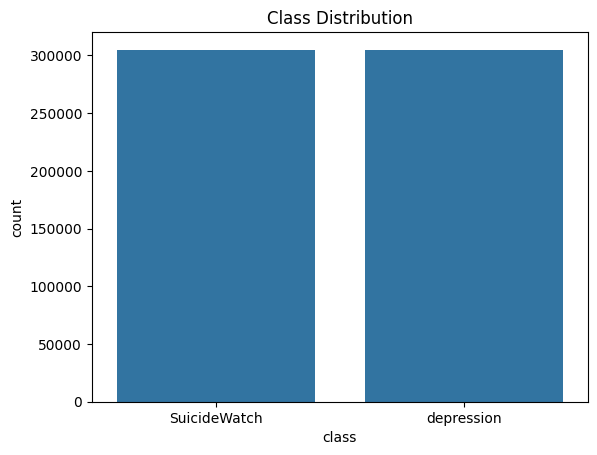

class
SuicideWatch    0.500001
depression      0.499999
Name: proportion, dtype: float64


In [170]:
#Step 1: Data Peek
#let's load the dataset and look some general info
#loading the dataframe
data_df=pd.read_csv('/Users/abdulaziz/Downloads/Machine Learning Project/Cleaned_Depression_Vs_Suicide.csv')


#inspecting the shape of the dataframe, this out to answer the question :
#"What does our data look like"
print(data_df.shape)

#Inspecting data integrity
print("\nMissing values per column:\n", data_df.isnull().sum())
print("\nDuplicate texts:",data_df.duplicated(subset=['text']).sum())

#Inspecting data integrity
print("\nMissing values per column:\n", data_df.isnull().sum())
print("\nDuplicate texts:",data_df.duplicated(subset=['text']).sum())

#Inspecting class balance
sns.countplot(x='class', data=data_df)
plt.title("Class Distribution")
plt.show()
print(data_df['class'].value_counts(normalize=True))

#both classes are equally distributed in this dataframe

Shape after dropping missing values: (609770, 2)

Remaining Missing Values: text     0
class    0
dtype: int64


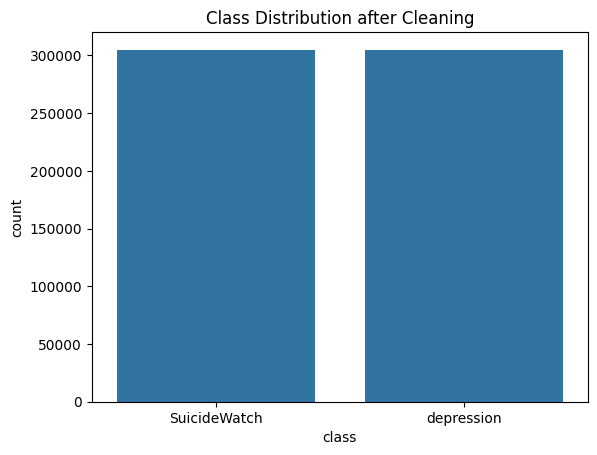

class
SuicideWatch    0.500002
depression      0.499998
Name: proportion, dtype: float64


In [171]:
# Removing rows with missing data
data_df = data_df.dropna().reset_index(drop=True)

# Verify that missing values were removed
print("Shape after dropping missing values:", data_df.shape)
print("\nRemaining Missing Values:", data_df.isnull().sum())

# Verify class balance after removal
sns.countplot(x='class', data=data_df)
plt.title("Class Distribution after Cleaning")
plt.show()
print(data_df['class'].value_counts(normalize=True))


In [172]:
# Step 2: Check size & make train/val/test splits – “What's the data size? How do you split the training, validation, and testing set?”
# Let’s see how many samples we have and then carve out 20% test, 10% validation.
from sklearn.model_selection import train_test_split

print("Total samples:", len(data_df))

# 80/20 train-test
train_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df['class'], random_state=42)
# from the 80% train, take 12.5% as validation >> overall 70/10/20
train_df, val_df  = train_test_split(train_df, test_size=0.125, stratify=train_df['class'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# this will answer the guideline question : What’s the data size? How do you split the training, validation, and testing set?


Total samples: 609770
Train: 426839, Val: 60977, Test: 121954


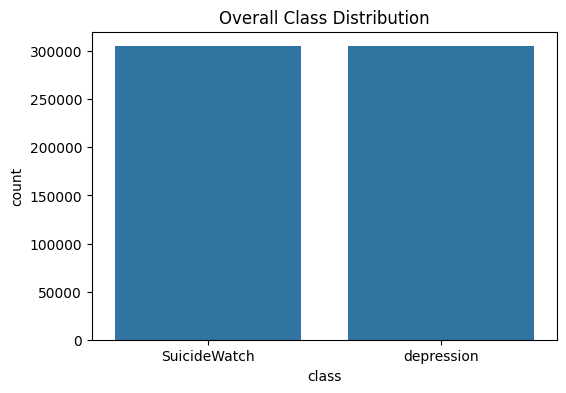

Overall proportions:
 class
SuicideWatch    0.500002
depression      0.499998
Name: proportion, dtype: float64


In [173]:
# Step 3: Target distribution – “What is the distribution of the target variable?”
# Let’s double-check class balance in our full dataset.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='class', data=data_df)
plt.title("Overall Class Distribution")
plt.show()

print("Overall proportions:\n", data_df['class'].value_counts(normalize=True))

# this will answer the guideline question : What is the distribution of the target variable?


In [174]:
# Step 4: Data preprocessing – “What data preprocessing steps do you perform?”
# Time to detect outliers, winsorize, and clean up gibberish tokens >30 chars.

import numpy as np
import re

# Compute raw lengths
data_df['char_count']   = data_df['text'].str.len()
data_df['word_count']   = data_df['text'].str.split().str.len()
data_df['avg_word_len'] = data_df['char_count'] / data_df['word_count']

# Find 1st & 99th percentiles
for col in ['char_count','word_count','avg_word_len']:
    p1, p99 = np.percentile(data_df[col], [1,99])
    print(f"{col}: 1% = {p1:.1f}, 99% = {p99:.1f}")

# This doesn't look right, a lot of entries have
# a lot of words and characters, probably noise ?
#let' cap the data at 99th percentile
for col in ['char_count','word_count','avg_word_len']:
    cap = data_df[col].quantile(0.99)
    data_df[f'{col}_cap'] = data_df[col].clip(upper=cap)

# Drop words >30 characters (gibberish)
def drop_long_words(text, max_len=30):
    return " ".join(w for w in text.split() if len(w)<=max_len)

data_df['clean_text'] = data_df['text'].apply(drop_long_words)

print(data_df[['char_count_cap','word_count_cap','avg_word_len_cap']].head())

#now let's re-inspect our code
print("\nTop values after capping:")
print(f"  char_count_cap   max = {data_df['char_count_cap'].max():.0f} characters")
print(f"  word_count_cap   max = {data_df['word_count_cap'].max():.0f} words")
print(f"  avg_word_len_cap max = {data_df['avg_word_len_cap'].max():.2f} chars/word")

# this will answer the guideline question : What data preprocessing steps do you perform?


char_count: 1% = 52.0, 99% = 6829.0
word_count: 1% = 9.0, 99% = 1312.0
avg_word_len: 1% = 4.5, 99% = 6.9
   char_count_cap  word_count_cap  avg_word_len_cap
0             481              91          5.285714
1             572             107          5.345794
2            1219             232          5.254310
3             516             109          4.733945
4             649             120          5.408333

Top values after capping:
  char_count_cap   max = 6829 characters
  word_count_cap   max = 1312 words
  avg_word_len_cap max = 6.87 chars/word


In [175]:
# Step 4b: lightweight stemming on `clean_text` using sklearn’s stop‑words

from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

ps       = PorterStemmer()
stop_eng = set(ENGLISH_STOP_WORDS)

def stem_text(text):
    return " ".join(
        ps.stem(w.lower())
        for w in text.split()
        if w.isalpha() and 2 <= len(w) <= 30 and w.lower() not in stop_eng
    )

data_df['clean_stems'] = data_df['clean_text'].apply(stem_text)

print("Original vs. Stemmed (first 5 rows):")
display(data_df[['clean_text','clean_stems']].head())


Original vs. Stemmed (first 5 rows):


,clean_text,clean_stems
0,Feeling a bit depressedI've been in a big low ...,feel bit big low know death actual cross mind ...
1,Was going to hang myself but didn't have guts ...,go hang gut kick away chairi set hang noos sta...
2,Have you ever maintained a poor friendship jus...,maintain poor friendship just friend friend gr...
3,I haven't felt positive feelings in a long tim...,felt posit feel long know train know happi kno...
4,Partners of those who suffer from depression; ...,partner suffer did work long term girlfriend s...


In [176]:
# Step 5: Feature space – “What's your feature space? How many features? What type of features?”
# We have 3 numeric features + a sparse TF-IDF bag‑of‑words.

from sklearn.feature_extraction.text import TfidfVectorizer

# Numeric features
num_feats = ['char_count_cap','word_count_cap','avg_word_len_cap']
print("Numeric features:", num_feats)

# TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=5000,
    token_pattern=r'\b[a-zA-Z]{2,30}\b',
    min_df=5, max_df=0.9
)
X_tfidf = vectorizer.fit_transform(data_df['clean_stems'])
print("TF-IDF shape:", X_tfidf.shape)

print(f"We’ve got {len(num_feats)} numeric features and {X_tfidf.shape[1]} TF-IDF features.")

# this will answer the guideline question : What's your feature space? How many features? What type of features?


Numeric features: ['char_count_cap', 'word_count_cap', 'avg_word_len_cap']
TF-IDF shape: (609770, 5000)
We’ve got 3 numeric features and 5000 TF-IDF features.


In [177]:
# Step 6 (revised): Token‑level exploration without taking too muich RAM (hopefully)

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def top_n_sparse(texts, n=10, ngram_range=(1,1), stop_words='english'):
    # build sparse DTM
    vec = CountVectorizer(
        token_pattern=r'\b[a-zA-Z]{2,30}\b',
        stop_words=stop_words,
        ngram_range=ngram_range,
        max_features=10000  # let's look at a reasonable size w/o crashing my ram..
    )
    X = vec.fit_transform(texts)
    # sum per column (feature)
    counts = X.sum(axis=0).A1
    # pair tokens with counts and pick top n
    features = vec.get_feature_names_out()
    top_idx = counts.argsort()[::-1][:n]
    return pd.DataFrame({
        'token':  features[top_idx],
        'count':  counts[top_idx]
    })

# now let's look top 20 unigrams for each class
for cls in data_df['class'].unique():
    print(f"\n Top 20 unigrams for class = {cls}")
    df_top = top_n_sparse(
        data_df.loc[data_df['class']==cls, 'clean_text'],
        n=20, ngram_range=(1,1)
    )
    display(df_top)

# and similarly for bigrams/trigrams
for cls in data_df['class'].unique():
    print(f"\n Top 10 bigrams for class = {cls}")
    display(top_n_sparse(
        data_df.loc[data_df['class']==cls, 'clean_text'],
        n=10, ngram_range=(2,2)
    ))
    print(f"\n Top 10 trigrams for class = {cls}")
    display(top_n_sparse(
        data_df.loc[data_df['class']==cls, 'clean_text'],
        n=10, ngram_range=(3,3)
    ))

#it seems there are a lot of noisy data that must be dealt with
# top-20 unigrams for suicide include "ve" which is probably "I've" as in I have
#let's add it as a stop word.

#another issue is that the non-suicide top 20 ngrams have noisy data like
# "filler" needs to be addressed.

#I will create step 6a to deal with these two issues.



 Top 20 unigrams for class = SuicideWatch


,token,count
0,just,536773
1,don,419752
2,like,344583
3,want,336052
4,life,296051
5,feel,283939
6,know,279917
7,ve,276755
8,people,190973
9,time,185430



 Top 20 unigrams for class = depression


,token,count
0,just,622217
1,like,474905
2,don,451440
3,feel,424516
4,know,336277
5,ve,322948
6,want,293148
7,life,284642
8,time,260227
9,really,248071



 Top 10 bigrams for class = SuicideWatch


,token,count
0,don know,105428
1,feel like,104741
2,don want,85676
3,just want,54103
4,want die,33790
5,just don,25301
6,don think,24227
7,feels like,17085
8,high school,16673
9,suicidal thoughts,16226



 Top 10 trigrams for class = SuicideWatch


,token,count
0,just don know,7514
1,don want live,6724
2,don know anymore,6506
3,just feel like,6402
4,just want die,6019
5,don feel like,5754
6,just don want,5642
7,don want die,5183
8,just want end,4855
9,fuck fuck fuck,3931



 Top 10 bigrams for class = depression


,token,count
0,feel like,151432
1,don know,130747
2,don want,69346
3,just want,41381
4,just don,28974
5,high school,28638
6,just feel,24585
7,feels like,22332
8,don think,22261
9,don feel,21694



 Top 10 trigrams for class = depression


,token,count
0,just don know,10829
1,just feel like,9193
2,don feel like,8467
3,don know anymore,7066
4,don really know,5617
5,feel like just,5275
6,feel like shit,5220
7,feel like ve,4725
8,just don want,4023
9,don know just,4015


In [178]:
# Step 6a: filter out BOTH generic stop‑words *and* troll‑y fillers, then re‑run token counts
#  – this fixes the “top words are just ‘the / to / and…’” problem

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import pandas as pd

#  build a big stop list: sklearn English stop‑words + our noise tokens
extra_noise   = {'ve', 'filler', 'cheese', 'sus', 'ur', 'mom', 'lt', 'gt', 'ni','don',}
stop_extended = list(ENGLISH_STOP_WORDS.union(extra_noise))   # must be a *list*, not a set

# strip those tokens out of clean_text and append them to clean_text2
def strip_stops_and_noise(text):
    return " ".join(w for w in text.split() if w.lower() not in stop_extended)

data_df['clean_text2'] = data_df['clean_text'].apply(strip_stops_and_noise)
# ‑‑ now “the / to / and”, “ve”, “filler”, “ur mom” etc. are gone

# helper: sparse top‑N counting (stays RAM‑safe, uses the SAME stop list)
def top_n_sparse(texts, n=20, ngram_range=(1,1)):
    vec = CountVectorizer(
        token_pattern=r'\b[a-zA-Z]{2,30}\b', #no special characters
        ngram_range=ngram_range,
        stop_words=stop_extended,
        max_features=10000
    )
    X = vec.fit_transform(texts)        # stays sparse
    counts = X.sum(axis=0).A1           # fast col sums
    feats  = vec.get_feature_names_out()
    top_idx = counts.argsort()[::-1][:n]
    return pd.DataFrame({'token': feats[top_idx], 'count': counts[top_idx]})

# re‑display top tokens after cleaning
for cls in data_df['class'].unique():
    print(f"\nTop 20 unigrams for class = {cls}")
    display(top_n_sparse(
        data_df.loc[data_df['class']==cls, 'clean_text2'],
        n=20, ngram_range=(1,1)
    ))

for cls in data_df['class'].unique():
    print(f"\nTop 10 bigrams for class = {cls}")
    display(top_n_sparse(
        data_df.loc[data_df['class']==cls, 'clean_text2'],
        n=10, ngram_range=(2,2)
    ))
    print(f"Top 10 trigrams for class = {cls}")
    display(top_n_sparse(
        data_df.loc[data_df['class']==cls, 'clean_text2'],
        n=10, ngram_range=(3,3)
    ))

# this will answer the guideline question : How do we handle residual noise *and* generic stop‑words before modeling?




Top 20 unigrams for class = SuicideWatch


,token,count
0,just,536773
1,like,344583
2,want,336052
3,life,296051
4,feel,283939
5,know,279917
6,people,190973
7,time,185430
8,really,170758
9,think,151812



Top 20 unigrams for class = depression


,token,count
0,just,622217
1,like,474905
2,feel,424516
3,know,336277
4,want,293148
5,life,284642
6,time,260227
7,really,248071
8,people,236401
9,depression,211888



Top 10 bigrams for class = SuicideWatch


,token,count
0,feel like,104763
1,just want,59760
2,want die,33800
3,just feel,17319
4,feels like,17086
5,high school,16673
6,suicidal thoughts,16228
7,dont know,13636
8,years ago,13589
9,want kill,13335


Top 10 trigrams for class = SuicideWatch


,token,count
0,just feel like,7047
1,just want die,6101
2,just want end,4876
3,fuck fuck fuck,3932
4,feel like just,3691
5,want die want,3658
6,feel like shit,2809
7,just want stop,2776
8,want live anymore,2563
9,feel like life,2380



Top 10 bigrams for class = depression


,token,count
0,feel like,151468
1,just want,45415
2,high school,28638
3,just feel,26701
4,feels like,22334
5,felt like,19705
6,years ago,17232
7,best friend,16182
8,long time,15304
9,makes feel,14536


Top 10 trigrams for class = depression


,token,count
0,just feel like,10143
1,feel like just,5471
2,feel like shit,5235
3,makes feel like,3477
4,make feel better,3437
5,feel like going,3261
6,long story short,2883
7,feel like life,2756
8,playing video games,2556
9,play video games,2545


In [179]:
#the top 10 trigrams for non-suicide seem to be noisy and troll-y (take a look at the output for step 6a)

# let's address that
# Step 6b: inspect how many docs each suspicious trigram occurs in

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# list the trigrams you’re worried about
suspect_trigrams = [
    'fuck fuck fuck', 'pop pop pop', 'cum cum cum',
    'cecil cecil cecil', 'eve eve eve',
    'jake paul fuck', 'fuck jake paul', 'paul fuck jake',
    'penis penis penis', 'amp amp amp'
]

# Vectorize *only* those trigrams, binary=True to count presence per doc
trigram_vec = CountVectorizer(
    vocabulary=suspect_trigrams,
    ngram_range=(3,3),
    token_pattern=r'\b[a-zA-Z]{2,30}\b',
    binary=True
)
X_tri = trigram_vec.fit_transform(data_df['clean_text2'])

# Convert to document‑frequency table
doc_freq = X_tri.sum(axis=0).A1
df_tri   = pd.DataFrame({
    'trigram': suspect_trigrams,
    'doc_freq': doc_freq
}).sort_values('doc_freq', ascending=False)

print(df_tri)

# it seems these noisy data is coming from less than 500 docs. which is less than
# .5% of the entire data. I will remove these documents without hurting the
#real genuine data


             trigram  doc_freq
0     fuck fuck fuck       488
9        amp amp amp        95
1        pop pop pop         2
8  penis penis penis         1
2        cum cum cum         0
3  cecil cecil cecil         0
4        eve eve eve         0
5     jake paul fuck         0
6     fuck jake paul         0
7     paul fuck jake         0


In [180]:
# Step 6c: drop ENTIRE documents that contain any of the “troll” trigrams
# (they occur in < 0.5 % of posts, so we can safely discard the rows)

# troll-y trigrams we’ve flagged as pure noise
troll_trigrams = [
    'fuck fuck fuck',
    'amp amp amp',
    'eve eve eve',
    'penis penis penis',
    'pop pop pop',
    'cum cum cum',
    'cecil cecil cecil',
    'jake paul fuck',
    'fuck jake paul',
    'paul fuck jake'
]

import re

# compile a single regex that matches any of those phrases (case‑insensitive)
troll_regex = re.compile(r'\b(?:' + r'|'.join(map(re.escape, troll_trigrams)) + r')\b', re.IGNORECASE)

# create a boolean mask: True = doc contains any troll trigram
troll_mask = data_df['clean_text2'].str.contains(troll_regex, regex=True)

print("Docs flagged as noise:", troll_mask.sum())   # should be ~ <500
print("Original size:", len(data_df))

# drop the noisy rows entirely
data_df = data_df.loc[~troll_mask].reset_index(drop=True)
print("Dataset size after drop:", len(data_df))

# clean_text3 = clean_text2 for the remaining docs
data_df['clean_text3'] = data_df['clean_text2']

# sanity‑check: show top trigrams again – troll phrases should be gone
for cls in data_df['class'].unique():
    print(f"\nTop 10 trigrams for class = {cls} (after dropping troll docs)")
    display(top_n_sparse(
        data_df.loc[data_df['class']==cls, 'clean_text3'],
        n=10, ngram_range=(3,3)
    ))

# this will answer the guideline question : How do we drop entire spam documents without hurting real data?


Docs flagged as noise: 412
Original size: 609770
Dataset size after drop: 609358

Top 10 trigrams for class = SuicideWatch (after dropping troll docs)


,token,count
0,just feel like,7039
1,just want die,6095
2,just want end,4873
3,feel like just,3690
4,want die want,3655
5,feel like shit,2804
6,just want stop,2773
7,want live anymore,2561
8,feel like life,2379
9,want die just,2313



Top 10 trigrams for class = depression (after dropping troll docs)


,token,count
0,just feel like,10141
1,feel like just,5470
2,feel like shit,5233
3,makes feel like,3476
4,make feel better,3434
5,feel like going,3258
6,long story short,2883
7,feel like life,2756
8,playing video games,2556
9,play video games,2544


In [181]:
# Step 6d: I thought I got rid of "ve" , but it's popping up again.. let's double check
#that it's gone
assert 've' in stop_extended

# rebuild clean_text3 from scratch
data_df['clean_text3'] = data_df['clean_text'].apply(
    lambda txt: " ".join(w for w in txt.split() if w.lower() not in stop_extended)
)

# quick check: does 've' survive tokenisation?
vec = CountVectorizer(stop_words=stop_extended)
X   = vec.fit_transform(data_df['clean_text3'])
assert 've' not in vec.get_feature_names_out()   # should raise if 've' slipped through

#no output , that's good !


In [182]:
# Step 7 (final): NMF topics using *exactly* the stop_extended list (which contains 've')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# sanity‑check: make sure 've' is in the stop list you built in Step 6a
assert 've' in stop_extended, "'ve' missing from stop_extended"

# we cleaned & deduped docs in Step 6c > clean_text3
assert 'clean_text3' in data_df.columns, "Run Step 6c first to create clean_text3"

#  TF‑IDF with that stop list (unigrams + bigrams, modest vocab)
vec = TfidfVectorizer(
    stop_words=stop_extended,            # < our master stop list
    token_pattern=r'\b[a-zA-Z]{2,30}\b',
    ngram_range=(1,2),
    max_df=0.8,
    min_df=50,
    max_features=2500
)
X = vec.fit_transform(data_df['clean_text3'])

#  Light NMF (6 topics, fewer iterations to stay RAM‑safe)
nmf = NMF(n_components=6, init='nndsvd', max_iter=120, random_state=42)
W   = nmf.fit_transform(X)
H   = nmf.components_

#  Show top 12 terms per topic; 've' should be gone
feat_names = vec.get_feature_names_out()
for k, topic_vec in enumerate(H):
    top_idx = topic_vec.argsort()[-12:][::-1]
    terms   = [feat_names[i] for i in top_idx]
    print(f"Topic {k}: {', '.join(terms)}")
# ok good no "ve" or other nonsense/troll-y tokens


Topic 0: time, life, years, school, friends, got, year, just, day, going, job, work
Topic 1: want, just, just want, die, want die, anymore, kill, life, live, end, know, pain
Topic 2: feel, like, feel like, just, feeling, people, just feel, feels, know, really, makes, feels like
Topic 3: im, dont, dont know, ive, dont want, im just, im going, like im, didnt, know im, ill, just dont
Topic 4: help, need, depression, know, talk, really, people, suicidal, thoughts, depressed, need help, suicide
Topic 5: fucking, fuck, hate, shit, people, life, just, just fucking, tired, kill, fucking hate, wish


/opt/anaconda3/envs/scipy_fix/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 120 reached. Increase it to improve convergence.
  warnings.warn(


In [213]:
# Step 7a: class‑specific NMF topics (prints top words for each of 4 topics)
#here I want to see what latent topics seem to dominate the dataset
#I will use Non-negative Matrix Factorization (NMF)
#refs :

# https://www.kaggle.com/discussions/general/177540

# https://stackoverflow.com/questions/33907243/topic-modelling-nmf-lda-scikit-learn?

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# make sure 'clean_text3' and stop_extended exist (run Step 6c first)
assert 'clean_text3' in data_df.columns
assert 've' in stop_extended

for cls in ['SuicideWatch', 'depression']:
    print(f"\n===== NMF topics for class = {cls} =====")

    # 1. grab all posts for this class
    texts_cls = data_df.loc[data_df['class'] == cls, 'clean_text3']

    # 2. TF‑IDF with the same stop list (unigrams + bigrams, modest vocab)
    vec = TfidfVectorizer(
        stop_words=stop_extended,
        token_pattern=r'\b[a-zA-Z]{2,30}\b',
        ngram_range=(1,2),
        max_df=0.8,
        min_df=50,
        max_features=5000
    )
    X_cls = vec.fit_transform(texts_cls)

    # 3. 4‑topic NMF for this class
    nmf_cls = NMF(n_components=4, init='nndsvd', max_iter=120, random_state=42)
    nmf_cls.fit(X_cls)

    # 4. print top 10 terms per topic
    feat_names = vec.get_feature_names_out()
    for k, comp in enumerate(nmf_cls.components_):
        top_idx = comp.argsort()[-10:][::-1]
        terms   = [feat_names[i] for i in top_idx]
        print(f"  Topic {k}: {', '.join(terms)}")


===== NMF topics for class = SuicideWatch =====
  Topic 0: life, time, know, just, years, going, people, help, really, friends
  Topic 1: want, just, die, just want, fucking, want die, anymore, kill, hate, tired
  Topic 2: im, dont, dont know, ive, dont want, im just, im going, fucking, im tired, know
  Topic 3: feel, like, feel like, just, know, feeling, just feel, really, feels, people

===== NMF topics for class = depression =====
  Topic 0: time, depression, school, years, really, year, got, friends, help, work
  Topic 1: feel, like, feel like, just, feeling, just feel, really, people, know, feels
  Topic 2: want, just, people, life, know, fucking, hate, just want, die, anymore
  Topic 3: im, dont, dont know, ive, dont want, im just, like im, didnt, know, know im


### Note 1: Strong overlap from the outset
Looking at the topics extracted by a simple non-negative matrix (NMF) we can see a heavy overlap between the two classes. This should be a guiding signal for the remaining analysis to expect heavy overlap. Conceptually speaking of course, this is not a surprise. 

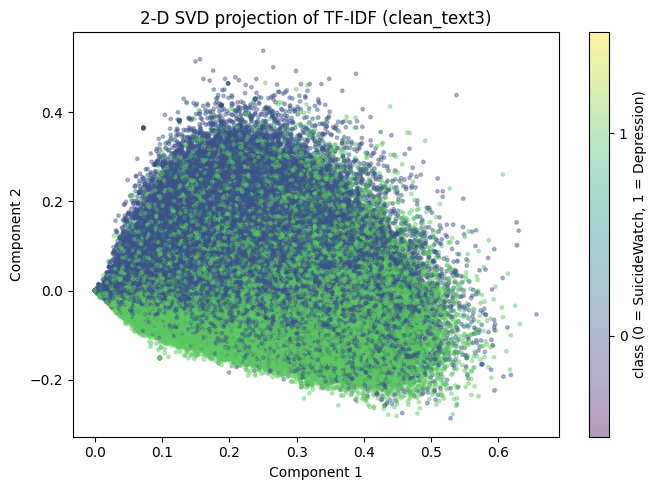

In [212]:
# Step 8: quick 2‑D visual check – can we separate the classes in reduced TF‑IDF space?
# this will answer the guideline question : Can we visualize class separation?

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Same TF‑IDF settings we’ve been using (stop_extended, uni+bi‑grams)
vec_8 = TfidfVectorizer(
    stop_words=stop_extended,
    token_pattern=r'\b[a-zA-Z]{2,30}\b',
    ngram_range=(1,2),
    max_df=0.8,
    min_df=50,
    max_features=5000
)

# 2. Build sparse TF‑IDF over ALL cleaned posts
X_all = vec_8.fit_transform(data_df['clean_text3'])

# 3. TruncatedSVD to 2 components (PCA for sparse matrices)
svd2 = TruncatedSVD(n_components=2, random_state=42)
proj = svd2.fit_transform(X_all)   # shape (N_docs, 2)

# 4. Scatter plot, colour by class
colors = data_df['class'].map({'SuicideWatch': 0, 'depression': 1})
plt.figure(figsize=(7,5))
plt.scatter(proj[:,0], proj[:,1], c=colors, alpha=0.4, s=6)
plt.title("2‑D SVD projection of TF‑IDF (clean_text3)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(ticks=[0,1], label='class (0 = SuicideWatch, 1 = Depression)')
plt.clim(-0.5,1.5)
plt.tight_layout()
plt.show()


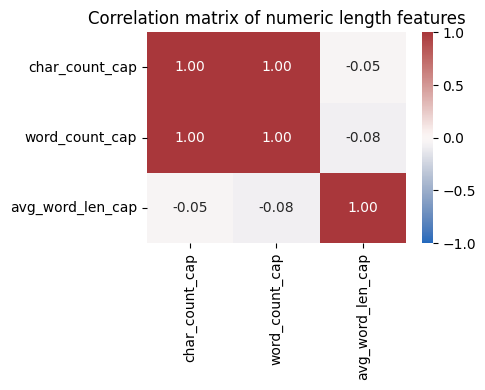

In [185]:
# Step 9: correlation check on our numeric features
# I am stealing this from EDA assignment 2 from last week
#this will answer the guideline question : Are any of our numeric features redundant?

import matplotlib.pyplot as plt
import seaborn as sns

#  let's plot the numeric columns we engineered back in Step 4
num_cols = ['char_count_cap', 'word_count_cap', 'avg_word_len_cap']

# sanity‑check that they exist
missing = [c for c in num_cols if c not in data_df.columns]
assert not missing, f"Run Step 4 first: missing {missing}"

#  compute correlation matrix
corr = data_df[num_cols].corr()

# plot it
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='vlag', fmt=".2f")
plt.title("Correlation matrix of numeric length features")
plt.tight_layout()
plt.show()

# quick interpretation
#   If I see correlations |ρ| > ~0.8, you might drop one of the pair
#  Here we expect char_count_cap ~ word_count_cap to be highly correlated,
#   while avg_word_len_cap should be largely independent.


Dropped word_count_cap (nearly identical to char_count_cap)
Numeric features we’ll keep: ['char_count_cap', 'avg_word_len_cap']


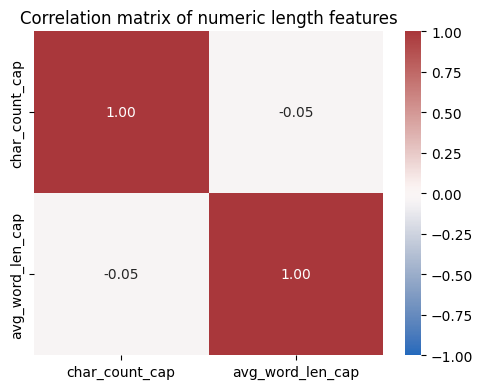

In [186]:
# Step 9a: prune redundant numeric feature (r ~ 0.99)
#  – we keep char_count_cap and drop word_count_cap

# 1. drop the column in‑place
if 'word_count_cap' in data_df.columns:
    data_df.drop(columns=['word_count_cap'], inplace=True)
    print("Dropped word_count_cap (nearly identical to char_count_cap)")

# 2. update our numeric‑feature list for the next steps
num_cols = ['char_count_cap', 'avg_word_len_cap']
print("Numeric features we’ll keep:", num_cols)

#  let's calculate the correlation matrix again
corr = data_df[num_cols].corr()

# ok let's plot it to make sure no other collinearity exists
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='vlag', fmt=".2f")
plt.title("Correlation matrix of numeric length features")
plt.tight_layout()
plt.show()

In [221]:
#print data_df columns
print("Final DataFrame columns:", data_df.columns)

Final DataFrame columns: Index(['text', 'class', 'char_count', 'word_count', 'avg_word_len',
       'char_count_cap', 'avg_word_len_cap', 'clean_text', 'clean_stems',
       'clean_text2', 'clean_text3'],
      dtype='object')


# Supervised Learning Starts Here ! 

## I will compare a tree-based model (random forest classifier) and a linear-based model (Logistic Regression Classifier )

## Note 2: Improved Hyperparameter finetuning 

Following Ashlynn's suggestion of optimized hyperparameter finetuning , I will be using the proper hyperparametuning of GridSearchCV instead of doing a one-by-one tuning. The point of doing one-by-one approach was to demonstrate a live-tuning of the parameters and seeing the accuracy improve slowly. However, as Ashlynn pointed out , it is not efficient and might actually miss specific combinations that are more efficient. 

In [284]:
from sklearn.model_selection import train_test_split

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)


In [285]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(20, 80),
    'max_depth': [None, 2, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=2,
    scoring='accuracy',
    n_jobs=1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_rf_train, y_rf_train)
best_rf = random_search_rf.best_estimator_


Fitting 2 folds for each of 20 candidates, totalling 40 fits


#### 3.2: Top 20 Features in Terms of Importance

In [260]:
# Correct vectorizer
feature_names = np.append(vectorizer.get_feature_names_out(), ['char_count_cap', 'avg_word_len_cap'])

# Sanity check
assert len(feature_names) == len(best_rf.feature_importances_), \
    f"Mismatch: {len(feature_names)} features but {len(best_rf.feature_importances_)} importances"

# Proceed
importances = best_rf.feature_importances_

feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

top_features_df = feature_df.sort_values(by='importance', ascending=False).head(20).reset_index(drop=True)
print(top_features_df)


             feature  importance
0         depression    0.015939
1   avg_word_len_cap    0.009782
2               kill    0.008996
3     char_count_cap    0.008914
4            suicide    0.008162
5          depressed    0.006951
6                die    0.006531
7               want    0.005989
8               feel    0.005884
9               like    0.005255
10              just    0.004507
11              life    0.004372
12               end    0.004253
13           anymore    0.004214
14               don    0.004016
15          suicidal    0.003969
16              live    0.003723
17              know    0.003549
18            really    0.003548
19           feeling    0.003214


#### Note 3.3: Discussion of RF Classifier 

Through optimizing the hyperparameters for the RandomForest Classifier , we were able to achieve about 77% accuracy and recall. Not terrible numbers , but not super great. Keep in mind that we are more concerned about Type I error (missing potential suicide-ideation texts). 

The top 20 features were also revealing. Odd features that stood out were the numerical features (avg_word_len_cap) and (char_count_cap). We'll see if this becomes a recurring theme throughout the logistic regression. 


In [286]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist_logreg = {
    'C': uniform(loc=0.1, scale=2),
    'solver': ['liblinear'],
    'penalty': ['l2'],
    'class_weight': ['balanced', None],
    'fit_intercept': [True, False],
    'max_iter': [1000]
}

logreg = LogisticRegression()
random_search_logreg = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist_logreg,
    n_iter=40,
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42
)

random_search_logreg.fit(X_rf_train, y_rf_train)
best_logreg = random_search_logreg.best_estimator_


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END C=0.849080237694725, class_weight=balanced, fit_intercept=True, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=0.849080237694725, class_weight=balanced, fit_intercept=True, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=0.849080237694725, class_weight=balanced, fit_intercept=True, max_iter=1000, penalty=l2, solver=liblinear; total time=   1.0s
[CV] END C=1.5639878836228103, class_weight=balanced, fit_intercept=True, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=1.5639878836228103, class_weight=balanced, fit_intercept=True, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=1.5639878836228103, class_weight=balanced, fit_intercept=True, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=0.412037280884873, class_weight=balanced, fit_intercept=True, max_iter=1000, penalty=l2, solver=liblin

In [267]:
import numpy as np
import pandas as pd

# Get the correct feature names from the trained vectorizer and numeric column names
feature_names = np.append(vectorizer.get_feature_names_out(), ['char_count_cap', 'avg_word_len_cap'])

# Ensure the number of features matches the number of coefficients
assert len(feature_names) == len(best_logreg.coef_[0]), \
    f"Feature name count ({len(feature_names)}) and coefficient count ({len(best_logreg.coef_[0])}) do not match"

# Extract coefficients
coefs = best_logreg.coef_[0]

# Create DataFrame with features and coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
})

# Sort and extract top features
top_nonsuicide = coef_df.sort_values(by='coefficient', ascending=False).head(15).reset_index(drop=True)
top_suicide = coef_df.sort_values(by='coefficient', ascending=True).head(15).reset_index(drop=True)

# Display results
print("\nTop features indicative of class 1 (suicide):")
print(top_suicide)

print("\nTop features indicative of class 0 (non-suicide):")
print(top_nonsuicide)



Top features indicative of class 1 (suicide):
       feature  coefficient
0     suicidal    -6.863474
1        x200b    -6.302766
2      suicide    -5.345959
3         kill    -5.029807
4       ending    -4.605354
5        covid    -4.378026
6          die    -3.900630
7          gun    -3.729391
8          end    -3.714226
9      killing    -3.655663
10     goodbye    -3.622767
11      method    -3.449850
12  quarantine    -3.338201
13    overdose    -3.217156
14      killed    -2.909435

Top features indicative of class 0 (non-suicide):
        feature  coefficient
0    depression    10.952869
1     depressed     5.834222
2          rant     3.763736
3           dae     3.233558
4    depressive     2.699351
5    motivation     2.613774
6           bed     2.612996
7      facebook     2.502383
8        doctor     2.490496
9        needed     2.445598
10           tl     2.435927
11           dr     2.423259
12         http     2.372439
13  depressioni     2.332317
14        start    

# Accuracy Comparison and Error analysis

## Accuracy Comparison 
### Let's compare both models on the score that actually matters for us in this case , which is recall score. 
#### the reason why recall matters more than the others is because we prioritize avoiding false negatives (suicide ideation undetected) than false positives (non-suicide ideation detected). Basically we are more wary of a type I error than we are of a type II error. 

In [268]:
# Use the original vectorizer that trained best_rf
# Make sure you are NOT refitting vectorizer again anywhere
feature_names_rf = np.append(vectorizer.get_feature_names_out(), ['char_count_cap', 'avg_word_len_cap'])

# Confirm dimensions match
assert len(feature_names_rf) == len(best_rf.feature_importances_), \
    f"{len(feature_names_rf)} feature names vs {len(best_rf.feature_importances_)} importances"

# Create DataFrame
rf_df = pd.DataFrame({
    'feature': feature_names_rf,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

top_features_rf = rf_df.head(15)

print("\nTop features overall (Random Forest):")
print(top_features_rf)



Top features overall (Random Forest):
                feature  importance
18886        depression    0.015939
75598  avg_word_len_cap    0.009782
38087              kill    0.008996
75597    char_count_cap    0.008914
64312           suicide    0.008162
18811         depressed    0.006951
19719               die    0.006531
72515              want    0.005989
26210              feel    0.005884
39692              like    0.005255
37729              just    0.004507
39454              life    0.004372
23411               end    0.004253
5928            anymore    0.004214
21175               don    0.004016


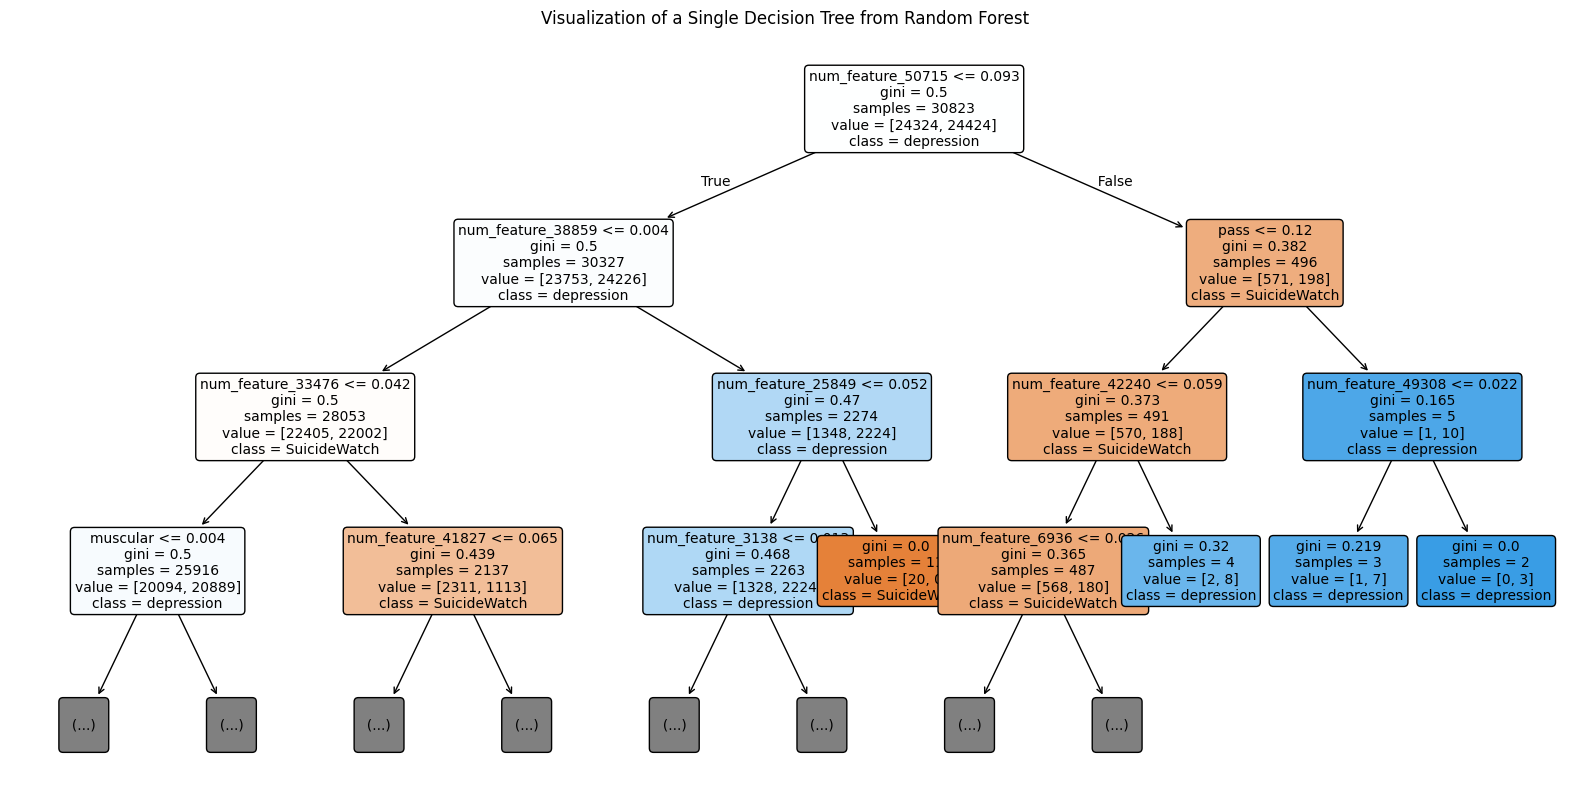

In [313]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# --- Build the correct list of feature names ---
tfidf_feature_names = vectorizer.get_feature_names_out().tolist()
# Check how many extra columns were added (e.g., numeric features)
n_extra_features = X_combined.shape[1] - len(tfidf_feature_names)

# Add placeholder names or actual numeric feature names
if n_extra_features == 2:
    numeric_feature_names = ['char_count_cap', 'avg_word_len_cap']
elif n_extra_features > 0:
    numeric_feature_names = [f'num_feature_{i}' for i in range(n_extra_features)]
else:
    numeric_feature_names = []

all_feature_names = tfidf_feature_names + numeric_feature_names

# --- Visualize the first tree in the forest ---
plt.figure(figsize=(20, 10))
plot_tree(
    best_rf.estimators_[0],
    max_depth=3,
    feature_names=all_feature_names,
    class_names=best_rf.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Visualization of a Single Decision Tree from Random Forest")
plt.show()


## Error Analysis 

### We will utilize the confusion matrix to identify the severity of both types of errors, and just according to the model that decreases the Type I error (false negatives).
### We will also take a closer look at some of the examples of the errors detected.

In [272]:
from sklearn.model_selection import train_test_split
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)


 Accuracy Comparison
Random Forest Accuracy (on test set): 0.7658980881266924
Logistic Regression Accuracy (on test set): 0.7875605153031919

 Classification Report - Random Forest
              precision    recall  f1-score   support

SuicideWatch       0.77      0.76      0.77      6093
  depression       0.77      0.77      0.77      6094

    accuracy                           0.77     12187
   macro avg       0.77      0.77      0.77     12187
weighted avg       0.77      0.77      0.77     12187


 Classification Report - Logistic Regression
              precision    recall  f1-score   support

SuicideWatch       0.79      0.79      0.79      6093
  depression       0.79      0.79      0.79      6094

    accuracy                           0.79     12187
   macro avg       0.79      0.79      0.79     12187
weighted avg       0.79      0.79      0.79     12187



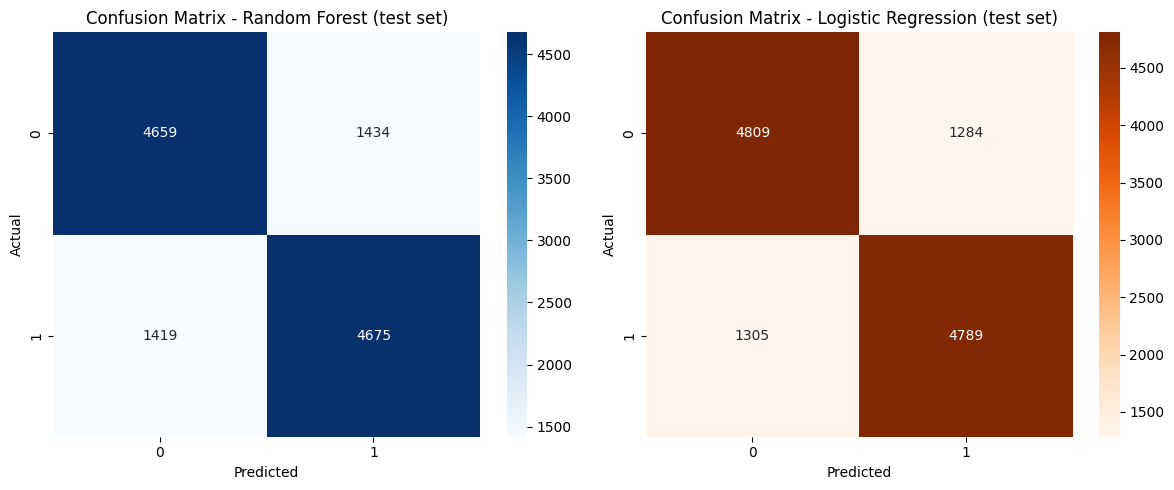

In [287]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict using the test set from X_combined
y_pred_rf = best_rf.predict(X_rf_test)
y_pred_logreg = best_logreg.predict(X_rf_test)

# Accuracy
print(" Accuracy Comparison")
print("Random Forest Accuracy (on test set):", accuracy_score(y_rf_test, y_pred_rf))
print("Logistic Regression Accuracy (on test set):", accuracy_score(y_rf_test, y_pred_logreg))

# Classification reports
print("\n Classification Report - Random Forest")
print(classification_report(y_rf_test, y_pred_rf))

print("\n Classification Report - Logistic Regression")
print(classification_report(y_rf_test, y_pred_logreg))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_rf = confusion_matrix(y_rf_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title("Confusion Matrix - Random Forest (test set)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

cm_logreg = confusion_matrix(y_rf_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', ax=axes[1], cmap='Oranges')
axes[1].set_title("Confusion Matrix - Logistic Regression (test set)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


### Error Examples
#### Let's look at where both models fail , especially in a false negative 

In [290]:
# Before vectorizing, keep track of test texts
X_text = sampled_df['text']
y = sampled_df['class']

from sklearn.model_selection import train_test_split
X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF
X_tr = vectorizer.fit_transform(X_text_train)
X_te = vectorizer.transform(X_text_test)

# Fit models
best_rf.fit(X_tr, y_train)
best_logreg.fit(X_tr, y_train)

# Predict
y_pred_rf = best_rf.predict(X_te)
y_pred_logreg = best_logreg.predict(X_te)

# Misclassification Analysis
mis_rf = y_pred_rf != y_test
mis_logreg = y_pred_logreg != y_test

print("\n*** Random Forest Misclassifications:")
for text, true, pred in zip(X_text_test[mis_rf][:3], y_test[mis_rf][:3], y_pred_rf[mis_rf][:3]):
    print(f"True: {true} | Pred: {pred}\n{text}\n")

print("*** Logistic Regression Misclassifications:")
for text, true, pred in zip(X_text_test[mis_logreg][:3], y_test[mis_logreg][:3], y_pred_logreg[mis_logreg][:3]):
    print(f"True: {true} | Pred: {pred}\n{text}\n")



*** Random Forest Misclassifications:
True: SuicideWatch | Pred: depression
I took some pillsMy doctor accidentally prescribed me mood stabilizers with the prescription too high one dosage left me with serotonin syndrome on a whim I just self harmed and took 4. I want to take more but something is telling me not to. I feel like a coward I just want this to be over I want to stop living.

True: depression | Pred: SuicideWatch
Thinking of ending it all now. Dont know what to do anymore or where to get help from :(So I have been depressed for more than 1 year. I have gotten help forom counsellors and other doctors who treat emotional problems but they have all been in vain. It seems they dont know what I am going through or dont understand it. I am in 11th grade and failed the normal exams. I have make up exams for which I am studying but no matter how much I study, I just cant do it. Parents said that they would kick me out of house if I fail and keep telling me why I am alive. I am mak

### Error analysis Discussion

The overall numbers seem to reflect that the logistic classifier seems to have the much upper hand in reducing type I error with a difference of around 2000 less errors. The examples seem to highlight two things : 

1. ### The posts that that were flagged as suicidewatch contained truly suicidal themes and suicidal ideation, although it originated in the r/depression reddit.

As discussed in the beginning of this project, this overlap is expected. This kind of error is acceptable (even welcomed) given these conditions. 

2. ### The false negatives (posts flagged as depression but were truly suicidal) contained keywords indicative of typical r/depression posts
These posts discussed pills , doctors appointments. They also mention depression a lot, which seems to confuse the two classes.



# Verdict : 

*drum roll*

# Logistic Regression classifier has the upperhand not only in generic accuracy methods, but in avoiding the errors that are most harmful for this purpose of this project

# Unsupervised Learning 

### For the remainder of this markdown notebook , We will try to understand what topics might guide our dileneation between suicidewatch-listed texts and r/depression posts

In [291]:
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import pandas as pd

# Subsample 10% of the data (stratified by class)
sample_df = resample(
    data_df,
    n_samples=int(0.1 * len(data_df)),
    stratify=data_df['class'],
    random_state=42
)

# Step 1: Vectorize the text data using same vectorizer config
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_text = vectorizer.fit_transform(sample_df['clean_text3'])

# Optional: scale numeric features before combining
scaler = StandardScaler(with_mean=False)
X_numeric = scaler.fit_transform(sample_df[['char_count_cap', 'avg_word_len_cap']])

# Combine TF-IDF and numeric features
X = hstack((X_text, X_numeric))


For n_clusters = 2, the mean squared error is: 31185531079.146
For n_clusters = 3, the mean squared error is: 14326330433.796
For n_clusters = 4, the mean squared error is: 7960248175.770
For n_clusters = 5, the mean squared error is: 4978508482.127
For n_clusters = 6, the mean squared error is: 3444221244.143
For n_clusters = 7, the mean squared error is: 2516550415.932
For n_clusters = 8, the mean squared error is: 1909775386.521
For n_clusters = 9, the mean squared error is: 1498213251.923
For n_clusters = 10, the mean squared error is: 1192244568.319


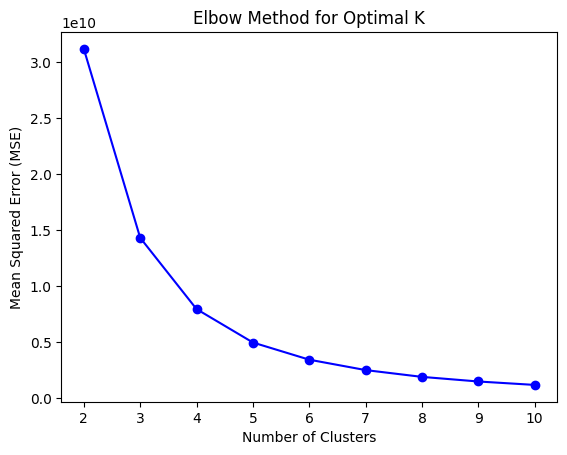

class    SuicideWatch  depression
cluster                          
0            0.437889    0.562111
1            0.567549    0.432451
2            0.401548    0.598452
3            0.397572    0.602428
4            0.419412    0.580588
5            0.480019    0.519981

Top words per cluster:
Cluster 3: time, life, didn, know, school, people, feel, got, things, want
Cluster 5: feel, want, know, life, people, time, think, depression, friends, help
Cluster 1: want, feel, know, life, help, die, kill, people, anymore, need
Cluster 0: feel, know, want, life, people, time, friends, think, going, depression
Cluster 4: feel, know, life, want, people, time, friends, think, things, years
Cluster 2: feel, life, know, time, want, people, friends, things, school, think


In [292]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import numpy as np


stop_extended.extend(["just", "like", "really"])

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words=stop_extended, max_features=10000)
X_text = vectorizer.fit_transform(sampled_df['clean_text3'])

# Combine text features with the numeric features
X = hstack((X_text, sampled_df[['char_count_cap', 'avg_word_len_cap']]))

# Perform K-means clustering for a range of cluster numbers and calculate MSE
mse_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    mse = kmeans.inertia_
    mse_scores.append(mse)
    print(f"For n_clusters = {n_clusters}, the mean squared error is: {mse:.3f}")

# Plot the MSE (Elbow Method)
plt.plot(cluster_range, mse_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Fit final model
n_clusters_optimal = 6
kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, random_state=42)
cluster_labels_optimal = kmeans_optimal.fit_predict(X)
sampled_df['cluster'] = cluster_labels_optimal

# Analyze clusters
cluster_analysis = sampled_df.groupby('cluster')['class'].value_counts(normalize=True).unstack(fill_value=0)
print(cluster_analysis)

# Get top words per cluster
def get_top_words_per_cluster(df, text_col, cluster_col, vectorizer, top_n=10):
    top_words = {}
    for cluster_num in df[cluster_col].unique():
        cluster_text = df[df[cluster_col] == cluster_num][text_col]
        X_cluster = vectorizer.transform(cluster_text)
        word_counts = np.asarray(X_cluster.sum(axis=0)).flatten()
        word_indices = word_counts.argsort()[::-1][:top_n]
        top_words[cluster_num] = [vectorizer.get_feature_names_out()[i] for i in word_indices]
    return top_words

top_words_per_cluster = get_top_words_per_cluster(sampled_df, 'clean_text3', 'cluster', vectorizer)
print("\nTop words per cluster:")
for cluster, words in top_words_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(words)}")


In [293]:
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

# Ensure class labels are encoded as integers (if they are strings)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
true_labels = le.fit_transform(sampled_df['class'])

# Predicted cluster labels
predicted_labels = sampled_df['cluster']

# Compute clustering metrics
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
homogeneity = homogeneity_score(true_labels, predicted_labels)
completeness = completeness_score(true_labels, predicted_labels)
v_measure = v_measure_score(true_labels, predicted_labels)

# Print the results
print(f"NMI Score:          {nmi:.4f}")
print(f"Homogeneity Score:  {homogeneity:.4f}")
print(f"Completeness Score: {completeness:.4f}")
print(f"V-measure Score:    {v_measure:.4f}")


NMI Score:          0.0071
Homogeneity Score:  0.0109
Completeness Score: 0.0053
V-measure Score:    0.0071


## So.. It seems like K-means isn't very helpful

The metric results are terrible (very close to zero). Furthermore, the topics identified did not help us separate the two topics (suicidewatch and depression). This is normal considering the linguistic closeness we observed earlier in this pipeline.

Let's now try LDA

In [294]:
from gensim import corpora
from gensim.models import LdaModel
import string
from pprint import pprint

import pyLDAvis
pyLDAvis.enable_notebook()

import pyLDAvis.gensim_models as gensimvis
from gensim.models.coherencemodel import CoherenceModel
print(pyLDAvis.__version__)


3.4.0


In [295]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize stopwords and lemmatizer
stop_words_nltk = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Add custom stopwords
custom_stopwords_lda = {
    'im', 'ive', 'id', 'youre', 'youd', 'youve', 'hes', 'shed', 'theyre', 'theyve',
    'dont', 'cant', 'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt',
    'mustnt', 'neednt', 'shant', 'shouldnt', 'wasnt', 'werent', 'wont', 'wouldnt', 'gon', 'wan',
    'http', 'https', 'www', 'com', 'org', 'net', 'edu', 'gov',
    've', 'filler', 'cheese', 'sus', 'ur', 'mom', 'lt', 'gt', 'ni',
    'mei', 'iti', 'helpi',
    'reddit', 'subreddit', 'post', 'comment', 'upvote', 'downvote', 'thread', 'op', 'ama', 'tl;dr', 'btw', 'faq', 'imo', 'irl',
    'article', 'link', 'image', 'video', 'source', 'removed', 'deleted'
}

stop_words_combined = stop_words_nltk.union(custom_stopwords_lda)

def clean_and_tokenize_lda(text):
    """Clean the text and return a list of tokens for LDA"""
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = word_tokenize(text)
    clean_tokens = [
        lemmatizer.lemmatize(token) for token in tokens
        if token not in stop_words_combined and len(token) > 2 and token.isalpha()
    ]
    return clean_tokens

# Apply to sampled_df
sampled_df['text_for_lda'] = sampled_df['text'].fillna('').astype(str)
sampled_df['tokens_lda'] = sampled_df['text_for_lda'].apply(clean_and_tokenize_lda)

print("Sample of tokenized texts for LDA (first 2 documents):")
print(sampled_df[['text', 'tokens_lda']].head(2))
print(f"\nNumber of documents processed: {len(sampled_df)}")


Sample of tokenized texts for LDA (first 2 documents):
                                                text  \
0  I feel like a monster.I'm writing this on my t...   
1  Looking for an actual reason not to end itHey ...   

                                          tokens_lda  
0  [feel, like, monster, writing, throwaway, acco...  
1  [looking, actual, reason, end, ithey, people, ...  

Number of documents processed: 60935


In [296]:
from gensim.corpora import Dictionary

# Create a dictionary from the tokenized LDA text
dictionary_lda = Dictionary(sampled_df['tokens_lda'].tolist())

# Filter out extremely rare and overly common words
dictionary_lda.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)

# Create the document-term matrix (corpus)
corpus_lda = [dictionary_lda.doc2bow(doc) for doc in sampled_df['tokens_lda'].tolist()]

print(f"\nNumber of unique tokens in dictionary (after filtering): {len(dictionary_lda)}")
print(f"Number of documents in corpus: {len(corpus_lda)}")



Number of unique tokens in dictionary (after filtering): 10000
Number of documents in corpus: 60935


In [297]:
from gensim.models import LdaModel

# Since corpus_lda and dictionary_lda are already created, we can proceed to LDA model training

# Set the parameters for an initial LDA model
num_topics_initial = 5 # Example, you'll determine this better with coherence scores
chunksize_lda = 2000
passes_lda = 10       # Number of passes through the corpus during training
iterations_lda = 50   # Fewer iterations for a quicker initial model
eval_every_lda = None 

# Create the LDA model
lda_model_initial = LdaModel(
    corpus=corpus_lda,
    id2word=dictionary_lda,
    num_topics=num_topics_initial,
    chunksize=chunksize_lda,
    passes=passes_lda,
    iterations=iterations_lda,
    eval_every=eval_every_lda,
    random_state=42,
    alpha='asymmetric', # Common heuristic for alpha
    eta='auto'          # Learn eta from data
)

print(f"\nInitial LDA model trained with {num_topics_initial} topics.")


Initial LDA model trained with 5 topics.


In [298]:
# Assuming 'lda_model_initial' is trained from the previous chunk

print(f"\nTop keywords for each of the {num_topics_initial} topics (initial model):")
# num_words specifies how many keywords to display for each topic
for topic_id, topic_words in lda_model_initial.print_topics(num_words=10):
    print(f"Topic {topic_id + 1}: {topic_words}")


Top keywords for each of the 5 topics (initial model):
Topic 1: 0.027*"want" + 0.023*"life" + 0.015*"get" + 0.013*"know" + 0.011*"fucking" + 0.010*"even" + 0.010*"anymore" + 0.009*"die" + 0.009*"day" + 0.009*"one"
Topic 2: 0.022*"know" + 0.019*"people" + 0.019*"friend" + 0.018*"really" + 0.016*"want" + 0.012*"thing" + 0.012*"think" + 0.011*"even" + 0.011*"talk" + 0.011*"time"
Topic 3: 0.024*"depression" + 0.014*"help" + 0.011*"time" + 0.010*"day" + 0.010*"year" + 0.010*"get" + 0.008*"anxiety" + 0.008*"really" + 0.008*"feeling" + 0.008*"thought"
Topic 4: 0.017*"job" + 0.017*"life" + 0.016*"school" + 0.015*"year" + 0.011*"get" + 0.011*"work" + 0.009*"even" + 0.009*"college" + 0.009*"time" + 0.007*"money"
Topic 5: 0.014*"year" + 0.012*"got" + 0.012*"time" + 0.011*"friend" + 0.011*"back" + 0.010*"day" + 0.009*"told" + 0.008*"month" + 0.008*"would" + 0.008*"one"


In [299]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Use notebook mode if running in a Jupyter environment
pyLDAvis.enable_notebook()

# Prepare the visualization data safely (avoid multiprocessing issues on macOS)
lda_vis_data = gensimvis.prepare(
    topic_model=lda_model_initial,
    corpus=corpus_lda,
    dictionary=dictionary_lda,
    mds='mmds',
    n_jobs=1  # Prevents 'mp_tracker_fd' KeyError on macOS
)

# Display the interactive visualization
pyLDAvis.display(lda_vis_data)


In [300]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np # If not already imported

# Now , just like in the previous submission, I will create a function to compute coherence values for a range of topics
# This function will compute coherence values for a range of topics
# and return the models, coherence values, and topic numbers for plotting

def compute_coherence_values_lda(dictionary, corpus, texts, limit, start=2, step=1, passes=5, iterations=50):
    coherence_values = []
    model_list = []
    topic_nums_list = list(range(start, limit + 1, step))
    
    print(f"\nCalculating C_v coherence for K from {start} to {limit} with step {step}...")
    for num_topics_iter in topic_nums_list:
        print(f"Training LDA model with {num_topics_iter} topics...")
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics_iter,
                         random_state=42,
                         chunksize=2000, # Can be adjusted
                         passes=passes,    # Fewer passes for faster tuning
                         iterations=iterations,
                         alpha='asymmetric',
                         eta='auto',
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_val = coherencemodel.get_coherence()
        coherence_values.append(coherence_val)
        print(f"Coherence (C_v) for {num_topics_iter} topics: {coherence_val:.4f}")
        
    return model_list, coherence_values, topic_nums_list

Coherence for 2 topics: 0.2925
Coherence for 3 topics: 0.2896
Coherence for 4 topics: 0.2930
Coherence for 5 topics: 0.3019
Coherence for 6 topics: 0.3123
Coherence for 7 topics: 0.3130
Coherence for 8 topics: 0.3250
Coherence for 9 topics: 0.3262
Coherence for 10 topics: 0.3308
Coherence for 11 topics: 0.3506
Coherence for 12 topics: 0.3331
Coherence for 13 topics: 0.3494
Coherence for 14 topics: 0.3409


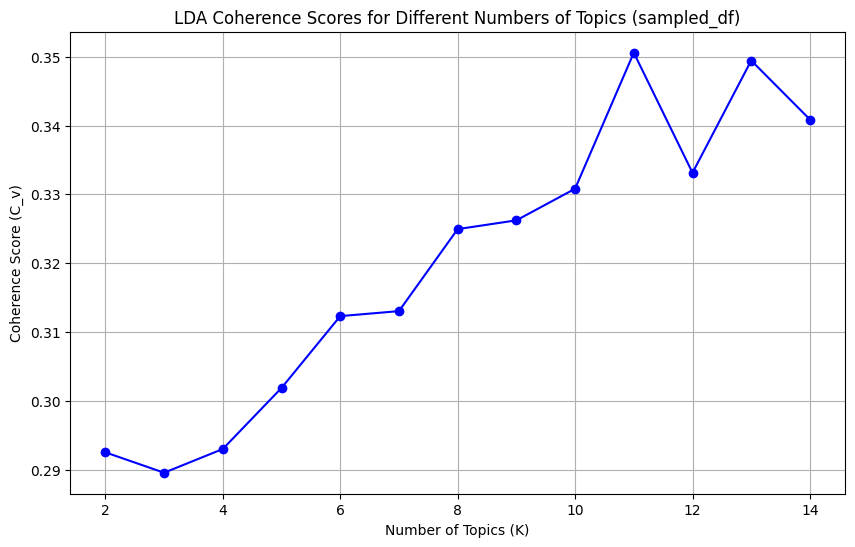

In [301]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

# Define topic search parameters
start_topics, limit_topics, step_topics = 2, 15 , 1

# Create dictionary and corpus from sampled_df
dictionary_lda = Dictionary(sampled_df['tokens_lda'])
dictionary_lda.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)
corpus_lda = [dictionary_lda.doc2bow(text) for text in sampled_df['tokens_lda']]

# Function to compute coherence for multiple topic counts
def compute_coherence_values_lda(dictionary, corpus, texts, start, limit, step, passes=2, iterations=25):
    model_list = []
    coherence_values = []
    topic_range = list(range(start, limit, step))
    
    for num_topics in topic_range:
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=passes,
            iterations=iterations,
            eval_every=None
        )
        model_list.append(model)

        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        coherence_values.append(coherence)
        print(f"Coherence for {num_topics} topics: {coherence:.4f}")

    return model_list, coherence_values, topic_range

# Run coherence evaluation
model_list_lda, coherence_values_lda, topic_nums_lda = compute_coherence_values_lda(
    dictionary=dictionary_lda, 
    corpus=corpus_lda, 
    texts=sampled_df['tokens_lda'], 
    start=start_topics,
    limit=limit_topics,
    step=step_topics,
    passes=2,
    iterations=25
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(topic_nums_lda, coherence_values_lda, 'bo-')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score (C_v)")
plt.title("LDA Coherence Scores for Different Numbers of Topics (sampled_df)")
plt.grid(True)
plt.show()


### Note 4: The optimal number of topics is 12 according to the plot

In [302]:
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


# --- 1. Train the Final LDA Model with K=12 ---
optimal_num_topics = 12
chunksize_final_lda = 2000
passes_final_lda = 15       # You can increase passes for better quality if time permits
iterations_final_lda = 100  # You can increase iterations for better quality
eval_every_final_lda = None # Set to None for production model or e.g., 10 to log perplexity

print(f"Training final LDA model with {optimal_num_topics} topics...")
lda_model_final = LdaModel(
    corpus=corpus_lda,
    id2word=dictionary_lda,
    num_topics=optimal_num_topics,
    chunksize=chunksize_final_lda,
    passes=passes_final_lda,
    iterations=iterations_final_lda,
    eval_every=eval_every_final_lda,
    random_state=42,
    alpha='asymmetric', 
    eta='auto',
    per_word_topics=True # Recommended for pyLDAvis
)
print("Final LDA model trained.")




Training final LDA model with 12 topics...
Final LDA model trained.


In [303]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from joblib import parallel_backend
import multiprocessing

# Patch multiprocessing to avoid loky bug
multiprocessing.set_start_method("fork", force=True)

print(f"\nTop keywords for each of the {optimal_num_topics} topics (final model):")
for topic_id, topic_words in lda_model_final.print_topics(num_words=10):
    print(f"Topic {topic_id + 1}: {topic_words}")

print("\nPreparing LDA visualization with pyLDAvis (this might take a moment)...")

# Optional: Display in Jupyter Notebook
pyLDAvis.enable_notebook()

# Force pyLDAvis to run in single-threaded mode
with parallel_backend('threading', n_jobs=1):  # avoid loky altogether
    lda_visualization_data = gensimvis.prepare(
        lda_model_final, corpus_lda, dictionary_lda, mds='mmds'
    )

print("Visualization data prepared. Displaying now...")
pyLDAvis.display(lda_visualization_data)



Top keywords for each of the 12 topics (final model):
Topic 1: 0.037*"get" + 0.022*"kill" + 0.021*"want" + 0.020*"head" + 0.019*"suicide" + 0.016*"die" + 0.014*"going" + 0.012*"end" + 0.010*"day" + 0.009*"think"
Topic 2: 0.020*"parent" + 0.018*"dad" + 0.017*"mother" + 0.015*"family" + 0.015*"told" + 0.014*"know" + 0.013*"would" + 0.011*"brother" + 0.011*"said" + 0.010*"tell"
Topic 3: 0.047*"depression" + 0.025*"anxiety" + 0.020*"year" + 0.015*"medication" + 0.012*"taking" + 0.011*"doctor" + 0.011*"med" + 0.010*"month" + 0.010*"week" + 0.009*"day"
Topic 4: 0.020*"people" + 0.018*"life" + 0.016*"thing" + 0.010*"time" + 0.009*"way" + 0.009*"would" + 0.008*"think" + 0.008*"something" + 0.008*"make" + 0.007*"thought"
Topic 5: 0.054*"help" + 0.027*"need" + 0.023*"know" + 0.017*"someone" + 0.014*"want" + 0.014*"talk" + 0.013*"suicide" + 0.013*"please" + 0.012*"suicidal" + 0.012*"mental"
Topic 6: 0.025*"year" + 0.019*"time" + 0.016*"friend" + 0.014*"back" + 0.013*"got" + 0.013*"month" + 0.011

### Topic Mapping: Text Output vs pyLDAvis + Suggested Topic Titles

| Text Output Topic # | pyLDAvis Topic # | Suggested Topic Title                     | Keywords Mentioned                                                     |
|---------------------|------------------|-------------------------------------------|------------------------------------------------------------------------|
| 1                   | 7                | Suicidal Thoughts and Urge to Die         | get, kill, want, head, suicide, die, going, end, day, think            |
| 2                   | 10               | Family Conflict and Parental Struggles    | parent, dad, mother, family, told, know, would, brother, said, tell    |
| 3                   | 5                | Clinical Depression and Medication Management | depression, anxiety, year, medication, taking, doctor, med, month, week, day |
| 4                   | 2                | Philosophical Reflections and Meaning of Life | people, life, thing, time, way, would, think, something, make, thought |
| 5                   | 1                | Seeking Help and Suicidal Ideation        | help, need, know, someone, want, talk, suicide, please, suicidal, mental |
| 6                   | 6                | Timeline of Struggles and Personal History| year, time, friend, back, got, month, day, started, went, last         |
| 7                   | 8                | Loneliness and Interpersonal Relationships| friend, people, know, talk, really, want, one, even, someone, girl     |
| 8                   | 12               | Body Image and Perceptual Pain            | day, one, look, see, every, back, body, eye, pain, world               |
| 9                   | 11               | Explosive Anger and Despair               | fucking, shit, fuck, hate, life, fucked, stupid, piece, even, give     |
| 10                  | 4                | Hopelessness and Desire to Escape Life    | want, life, know, anymore, people, never, one, love, even, live        |
| 11                  | 9                | Emotional Turmoil and Confusion           | know, really, get, day, time, want, thing, feeling, even, think        |
| 12                  | 3                | Academic and Work-Related Stress          | job, school, get, year, work, college, life, money, even, class        |


In [304]:
# Compute topic distribution for each document in sampled_df
dominant_topics = []

for bow in corpus_lda:
    topic_probs = lda_model_final.get_document_topics(bow)
    if topic_probs:
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    else:
        dominant_topic = None
    dominant_topics.append(dominant_topic)

# Assign to DataFrame
sampled_df['dominant_lda_topic'] = dominant_topics


In [305]:
import pandas as pd
import numpy as np
from sklearn import metrics

print("--- Comparing K-Means and LDA Clustering Metrics (vs Ground Truth) ---")

try:
    # --- 1. Prepare True Labels (common for both evaluations) ---
    if 'class' not in sampled_df.columns:
        raise ValueError("'class' column for ground truth labels is missing from sampled_df.")
    
    y_true_mapped = sampled_df['class'].map({'depression': 0, 'SuicideWatch': 1})

    # --- 2. Evaluate K-Means ---
    if 'cluster_labels_optimal' not in globals():
        raise NameError("'cluster_labels_optimal' for K-Means not defined.")
    if len(y_true_mapped) != len(cluster_labels_optimal):
        print(f"Warning: Initial length mismatch for K-Means. y_true: {len(y_true_mapped)}, clusters: {len(cluster_labels_optimal)}. Will attempt to align via NaN filtering.")

    valid_mask_kmeans = y_true_mapped.notna()

    if len(valid_mask_kmeans) == len(cluster_labels_optimal):
        y_true_kmeans_final = y_true_mapped[valid_mask_kmeans].astype(int)
        cluster_labels_kmeans_final = cluster_labels_optimal[valid_mask_kmeans.to_numpy(dtype=bool)]

        if len(y_true_kmeans_final) > 1 and len(np.unique(y_true_kmeans_final)) > 1 and len(np.unique(cluster_labels_kmeans_final)) > 1:
            print("\nK-Means Metrics:")
            print(f"  NMI Score:          {metrics.normalized_mutual_info_score(y_true_kmeans_final, cluster_labels_kmeans_final):.4f}")
            print(f"  Homogeneity Score:  {metrics.homogeneity_score(y_true_kmeans_final, cluster_labels_kmeans_final):.4f}")
            print(f"  Completeness Score: {metrics.completeness_score(y_true_kmeans_final, cluster_labels_kmeans_final):.4f}")
            print(f"  V-measure Score:    {metrics.v_measure_score(y_true_kmeans_final, cluster_labels_kmeans_final):.4f}")
        else:
            print("K-Means: Not enough data or unique labels/clusters after filtering for K-Means.")
    else:
        print("K-Means: Could not align y_true and cluster_labels_optimal due to length differences after initial mapping.")

    # --- 3. Evaluate LDA (using dominant topic assignments) ---
    if 'dominant_lda_topic' not in sampled_df.columns:
        raise ValueError("'dominant_lda_topic' column missing from sampled_df for LDA evaluation.")

    lda_assignments_raw = sampled_df['dominant_lda_topic']
    valid_mask_lda = y_true_mapped.notna() & lda_assignments_raw.notna()

    y_true_lda_final = y_true_mapped[valid_mask_lda].astype(int)
    lda_assignments_final = lda_assignments_raw[valid_mask_lda].astype(int)

    if len(y_true_lda_final) > 1 and len(np.unique(y_true_lda_final)) > 1 and len(np.unique(lda_assignments_final)) > 1:
        print("\nLDA Metrics (based on dominant topic):")
        print(f"  NMI Score:          {metrics.normalized_mutual_info_score(y_true_lda_final, lda_assignments_final):.4f}")
        print(f"  Homogeneity Score:  {metrics.homogeneity_score(y_true_lda_final, lda_assignments_final):.4f}")
        print(f"  Completeness Score: {metrics.completeness_score(y_true_lda_final, lda_assignments_final):.4f}")
        print(f"  V-measure Score:    {metrics.v_measure_score(y_true_lda_final, lda_assignments_final):.4f}")
    else:
        print("LDA: Not enough data or unique labels/topics after filtering for LDA.")

except NameError as ne:
    print(f"NameError: {ne}. Please ensure all required variables (sampled_df, cluster_labels_optimal) are defined.")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


--- Comparing K-Means and LDA Clustering Metrics (vs Ground Truth) ---

K-Means Metrics:
  NMI Score:          0.0071
  Homogeneity Score:  0.0109
  Completeness Score: 0.0053
  V-measure Score:    0.0071

LDA Metrics (based on dominant topic):
  NMI Score:          0.0528
  Homogeneity Score:  0.1103
  Completeness Score: 0.0347
  V-measure Score:    0.0528


# LDA it is !

## Quantitatively Speaking 
The Adjust Rand score BARELY outscores the k - means method , but still better. However, I ran the entire evaluation to compare both k-means and LDA model from evaluation metrics presented in class , and LDA beats k-Means on every metric. 

## Qualitatively Speaking
Since the topics in the LDA model were much more coherent and made sense for exploration, I will use the LDA topics over the k-Means. I will run a code chunk below to measure the dominant topic in each document (reddit post) and then look at the distribution of classes across topics and determine which topics are salient in suicide labels. This will allow for a more qualitative approach to identifying and dileneating suicide ideation in text. 

In [306]:
import pandas as pd
import numpy as np

# --- 1. Assign Dominant Topic to Each Document (Threshold = 0.1) ---
dominant_topics = []
doc_topic_distributions = []

threshold = 0.00001  # Relaxed threshold

print(f"Assigning dominant topic to each document in sampled_df using threshold of {threshold}...")
for i, doc_bow in enumerate(corpus_lda):
    if not doc_bow:
        dominant_topics.append(np.nan)
        doc_topic_distributions.append([])
        continue

    topic_distribution = lda_model_final.get_document_topics(doc_bow, minimum_probability=0.0)
    doc_topic_distributions.append(topic_distribution)

    if topic_distribution:
        sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
        top_topic, top_prob = sorted_topics[0]
        if top_prob >= threshold:
            dominant_topics.append(top_topic)
        else:
            dominant_topics.append(np.nan)
    else:
        dominant_topics.append(np.nan)

# Ensure alignment with sampled_df
if len(dominant_topics) == len(sampled_df):
    sampled_df['dominant_lda_topic'] = dominant_topics
else:
    print(f"Warning: Length mismatch. Corpus has {len(corpus_lda)} docs, sampled_df has {len(sampled_df)} rows.")
    if len(dominant_topics) > len(sampled_df):
        sampled_df['dominant_lda_topic'] = dominant_topics[:len(sampled_df)]
    elif len(dominant_topics) < len(sampled_df) and len(dominant_topics) > 0:
        padded_topics = dominant_topics + [np.nan] * (len(sampled_df) - len(dominant_topics))
        sampled_df['dominant_lda_topic'] = padded_topics
    else:
        print("Cannot assign dominant topics due to mismatch and empty results.")

# --- 2. Analyze Class Label Distribution by Topic ---
if 'dominant_lda_topic' in sampled_df.columns and 'class' in sampled_df.columns:
    df_topics = sampled_df.dropna(subset=['dominant_lda_topic']).copy()
    df_topics['dominant_lda_topic'] = df_topics['dominant_lda_topic'].astype(int)

    print("\n--- Distribution of 'class' labels per LDA Topic ---")
    topic_class_counts = df_topics.groupby('dominant_lda_topic')['class'].value_counts().unstack(fill_value=0)
    print("\nCounts of 'suicide' vs 'non-suicide' labels for each topic:")
    print(topic_class_counts)

    topic_class_proportions = df_topics.groupby('dominant_lda_topic')['class'].value_counts(normalize=True).unstack(fill_value=0)
    print("\nProportions of 'suicide' vs 'non-suicide' labels for each topic:")
    print(topic_class_proportions)

    # --- 3. Keywords + Class Distribution ---
    print("\n--- Top Keywords and Class Distribution for each LDA Topic ---")
    topics_keywords = {}
    for topic_id, topic_words_str in lda_model_final.print_topics(num_topics=optimal_num_topics, num_words=10):
        topics_keywords[topic_id] = topic_words_str

    for topic_id in range(optimal_num_topics):
        print(f"\nTopic {topic_id + 1}:")
        print(f"  Keywords: {topics_keywords.get(topic_id, 'N/A')}")
        if topic_id in topic_class_proportions.index:
            print(f"  Class Proportions:")
            for class_label, prop in topic_class_proportions.loc[topic_id].items():
                print(f"    {class_label}: {prop:.2%}")
            print(f"  Class Counts:")
            for class_label, count in topic_class_counts.loc[topic_id].items():
                print(f"    {class_label}: {count}")
        else:
            print("  Class Proportions: No documents assigned to this topic.")

else:
    if 'dominant_lda_topic' not in sampled_df.columns:
        print("Error: 'dominant_lda_topic' column missing.")
    if 'class' not in sampled_df.columns:
        print("Error: 'class' column missing from sampled_df.")


Assigning dominant topic to each document in sampled_df using threshold of 1e-05...

--- Distribution of 'class' labels per LDA Topic ---

Counts of 'suicide' vs 'non-suicide' labels for each topic:
class               SuicideWatch  depression
dominant_lda_topic                          
0                           3382         577
1                           1204         691
2                            288        1742
3                           1948        3582
4                           1977        1585
5                           2807        3754
6                           2087        3541
7                            560         794
8                            254         123
9                          10128        3603
10                          3870        7839
11                          1936        2630

Proportions of 'suicide' vs 'non-suicide' labels for each topic:
class               SuicideWatch  depression
dominant_lda_topic                          
0              

In [307]:
import numpy as np

# --- Compute Average of Highest Topic Probabilities ---
highest_probs = []

for doc_bow in corpus_lda:
    if not doc_bow:
        continue
    topic_distribution = lda_model_final.get_document_topics(doc_bow, minimum_probability=0.0)
    if topic_distribution:
        top_prob = max(prob for _, prob in topic_distribution)
        highest_probs.append(top_prob)

if highest_probs:
    average_top_prob = np.mean(highest_probs)
    print(f"Average highest topic probability across all documents: {average_top_prob:.4f}")
else:
    print("No valid topic probabilities found.")


Average highest topic probability across all documents: 0.4436


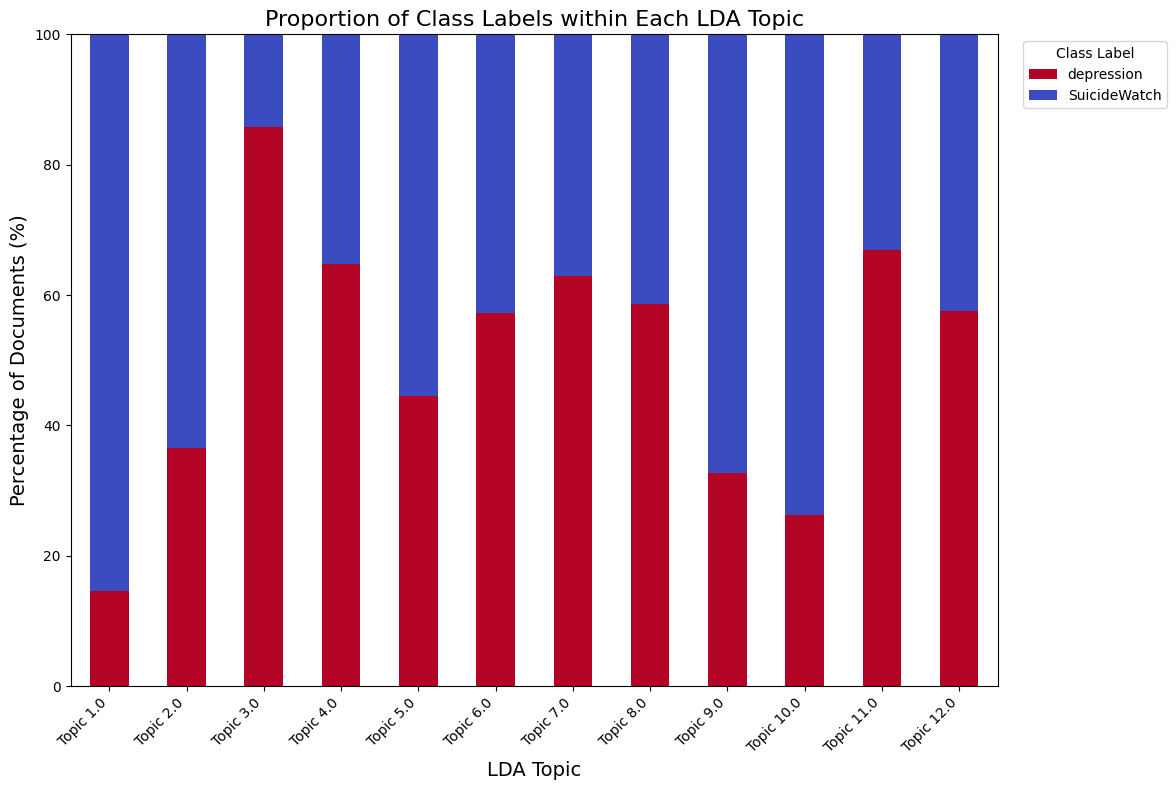



--- Topic Legend ---
Topic 1: Suicidal Thoughts and Urge to Die
Topic 2: Family Conflict and Parental Struggles
Topic 3: Clinical Depression and Medication Management
Topic 4: Philosophical Reflections and Meaning of Life
Topic 5: Seeking Help and Suicidal Ideation
Topic 6: Timeline of Struggles and Personal History
Topic 7: Loneliness and Interpersonal Relationships
Topic 8: Body Image and Perceptual Pain
Topic 9: Explosive Anger and Despair
Topic 10: Hopelessness and Desire to Escape Life
Topic 11: Emotional Turmoil and Confusion
Topic 12: Academic and Work-Related Stress


In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Corrected topic titles for LDA topics 0 through 11
topic_titles_list = [
    "Suicidal Thoughts and Urge to Die",             # Topic 0
    "Family Conflict and Parental Struggles",        # Topic 1
    "Clinical Depression and Medication Management", # Topic 2
    "Philosophical Reflections and Meaning of Life", # Topic 3
    "Seeking Help and Suicidal Ideation",            # Topic 4
    "Timeline of Struggles and Personal History",    # Topic 5
    "Loneliness and Interpersonal Relationships",    # Topic 6
    "Body Image and Perceptual Pain",                # Topic 7
    "Explosive Anger and Despair",                   # Topic 8
    "Hopelessness and Desire to Escape Life",        # Topic 9
    "Emotional Turmoil and Confusion",               # Topic 10
    "Academic and Work-Related Stress"               # Topic 11
]

# --- 1. Prepare data for plotting: Calculate class proportions per topic ---
if 'dominant_lda_topic' in sampled_df.columns and 'class' in sampled_df.columns:
    df_analyzable = sampled_df.dropna(subset=['dominant_lda_topic']).copy()
    
    if not df_analyzable.empty:
        df_analyzable.loc[:, 'dominant_lda_topic'] = df_analyzable['dominant_lda_topic'].astype(int)

        topic_class_proportions = (
            df_analyzable
            .groupby('dominant_lda_topic')['class']
            .value_counts(normalize=True)
            .mul(100)
            .unstack(fill_value=0)
        )

        # Ensure both class labels exist
        for col in ['depression', 'SuicideWatch']:
            if col not in topic_class_proportions.columns:
                topic_class_proportions[col] = 0.0

        topic_class_proportions = topic_class_proportions[['depression', 'SuicideWatch']]

        # --- 2. Plot the stacked bar chart ---
        if not topic_class_proportions.empty:
            fig, ax = plt.subplots(figsize=(14, 8))
            topic_class_proportions.plot(
                kind='bar',
                stacked=True,
                ax=ax,
                colormap='coolwarm_r'
            )

            ax.set_title('Proportion of Class Labels within Each LDA Topic', fontsize=16)
            ax.set_xlabel('LDA Topic', fontsize=14)
            ax.set_ylabel('Percentage of Documents (%)', fontsize=14)

            xtick_labels = [f"Topic {i + 1}" for i in topic_class_proportions.index]
            ax.set_xticklabels(xtick_labels, rotation=45, ha="right")

            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, title='Class Label', bbox_to_anchor=(1.02, 1), loc='upper left')

            plt.ylim(0, 100)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()

            ## --- 3. Topic Legend ---
            print("\n\n--- Topic Legend ---")
            for model_topic_id in sorted(topic_class_proportions.index):
                model_topic_id_int = int(model_topic_id)
                chart_label = f"Topic {model_topic_id_int + 1}"
                if 0 <= model_topic_id_int < len(topic_titles_list):
                    print(f"{chart_label}: {topic_titles_list[model_topic_id_int]}")
                else:
                    print(f"{chart_label}: [Title not defined for topic ID {model_topic_id_int}]")
        else:
            print("No data to plot: topic_class_proportions is empty.")
    else:
        print("No analyzable documents found in sampled_df after dropping NaNs in 'dominant_lda_topic'.")
else:
    if 'dominant_lda_topic' not in sampled_df.columns:
        print("Error: 'dominant_lda_topic' column not found in sampled_df.")
    if 'class' not in sampled_df.columns:
        print("Error: 'class' column not found in sampled_df.")


### Note 05: A Bit of Statistics 

Considering the difficulty of dileneating these two sets , it seems like we could benefit from employing a bit of statistics (rather than just eyeing the percentages) in evaluating the efficacy of the topics in identifying suicidewatch posts. 

Let's ask ourselves this question: _Does this topic signficiantly contains more/less SuicideWatch posts than mere chance (or base rate) ?_

In [316]:
from scipy.stats import binom_test

# Calculate the overall base rate of SuicideWatch
overall_suicide_rate = (sampled_df['class'] == 'SuicideWatch').mean()
print(f"Overall SuicideWatch rate: {overall_suicide_rate:.4f}")

# Get topic-class counts
topic_class_counts = pd.crosstab(sampled_df['dominant_lda_topic'], sampled_df['class'])

print("\nBinomial test for each topic (is SuicideWatch rate significantly different from base rate?):")
print("Topic\tSuicideWatch\tTotal\tProp\tP-value\t\tSignificant")

for topic_id in sorted(topic_class_counts.index):
    suicide_count = topic_class_counts.loc[topic_id].get('SuicideWatch', 0)
    total_count = topic_class_counts.loc[topic_id].sum()
    
    # Binomial test
    p_val = binom_test(suicide_count, total_count, overall_suicide_rate, alternative='two-sided')
    prop = suicide_count / total_count if total_count > 0 else 0
    sig = "YES" if p_val < 0.05 else "NO"
    
    print(f"{topic_id + 1:>2}\t{suicide_count:>5}\t\t{total_count:>5}\t{prop:.3f}\t{p_val:.4e}\t{sig}")


Overall SuicideWatch rate: 0.4999

Binomial test for each topic (is SuicideWatch rate significantly different from base rate?):
Topic	SuicideWatch	Total	Prop	P-value		Significant
1.0	 3382		 3959	0.854	0.0000e+00	YES
2.0	 1204		 1895	0.635	1.9973e-32	YES
3.0	  288		 2030	0.142	5.1143e-253	YES
4.0	 1948		 5530	0.352	1.9107e-108	YES
5.0	 1977		 3562	0.555	4.8855e-11	YES
6.0	 2807		 6561	0.428	1.2985e-31	YES
7.0	 2087		 5628	0.371	1.7225e-84	YES
8.0	  560		 1354	0.414	2.1900e-10	YES
9.0	  254		  377	0.674	9.9053e-12	YES
10.0	10128		13731	0.738	4.9407e-324	YES
11.0	 3870		11709	0.331	4.3955e-300	YES
12.0	 1936		 4566	0.424	9.1483e-25	YES


In [318]:

# Updated topic titles (1-indexed)
topic_titles = {
    1: "Suicidal Urges and Despair",
    2: "Family Relationships and Conflict",
    3: "Depression and Treatment",
    4: "General Reflections and Life Struggles",
    5: "Help-Seeking and Suicidal Thoughts",
    6: "Personal Narratives and Recovery",
    7: "Friendships and Social Support",
    8: "Body Image and Daily Experience",
    9: "Profanity-Laced Rage",
    10: "Existential Crisis and Hopelessness",
    11: "Emotional Fatigue and Uncertainty",
    12: "Work, School, and Financial Stress"
}


# Drop rows with NaN and convert to 1-indexed
df_valid = sampled_df.dropna(subset=['dominant_lda_topic']).copy()
df_valid['dominant_lda_topic'] = df_valid['dominant_lda_topic'].astype(int) + 1  # convert to 1-indexed

# Extract examples and keywords
example_posts = {}

for topic_num in sorted(df_valid['dominant_lda_topic'].unique()):
    # Get top keywords from LDA model (0-indexed)
    keywords = lda_model_final.show_topic(topic_num - 1, topn=10)
    keyword_list = ", ".join([f"{word}" for word, _ in keywords])

    # Get topic label and sample posts
    label = f"Topic {topic_num}: {topic_titles.get(topic_num, '[No title found]')}"
    match = df_valid[df_valid['dominant_lda_topic'] == topic_num]
    posts = match['text'].head(2).tolist()

    # Store output
    example_posts[label] = {
        "keywords": keyword_list,
        "posts": posts
    }

# Print output
for label, content in example_posts.items():
    print(f"\n--- {label} ---")
    print(f"Top Keywords: {content['keywords']}")
    for i, post in enumerate(content['posts'], 1):
        print(f"\nExample {i}:\n{post[:1000]}...\n")



--- Topic 1: Suicidal Urges and Despair ---
Top Keywords: get, kill, want, head, suicide, die, going, end, day, think

Example 1:
I hate myself... here's why. I wish I 
wasn't me.I posted the link to my original post. That's why I hate myself.

I guess I messed up the link... here: www.reddit.com/r/AskReddit/comments/x82kb/i_am_abusive_to_my_so_and_want_to_stop_what_do_i/...


Example 2:
I feel the urge getting strongerIt’s like a fire inside of me that keeps boiling higher and higher, and it burns like hell and I have to let it out to relieve myself from the pain. 

Self harm lets a little bit drip out but it still eventually refills. It’s going to boil over and I’m going to snap. I can feel it. I have to die. Please, God, let me die...


--- Topic 2: Family Relationships and Conflict ---
Top Keywords: parent, dad, mother, family, told, know, would, brother, said, tell

Example 1:
I just unsubbed from /r/eood, /r/loseit and /r/ddpyoga. I can't do it right now.I wanted to lose weight.

In [317]:
# --- Class Distribution Summary by LDA Topic ---
df_topics = sampled_df.dropna(subset=['dominant_lda_topic']).copy()
df_topics['dominant_lda_topic'] = df_topics['dominant_lda_topic'].astype(int)

# Counts
topic_class_counts = df_topics.groupby('dominant_lda_topic')['class'].value_counts().unstack(fill_value=0)
print("\nClass Counts per Topic:")
print(topic_class_counts)

# Proportions
topic_class_props = df_topics.groupby('dominant_lda_topic')['class'].value_counts(normalize=True).unstack(fill_value=0)
print("\nClass Proportions per Topic:")
print(topic_class_props)



Class Counts per Topic:
class               SuicideWatch  depression
dominant_lda_topic                          
0                           3382         577
1                           1204         691
2                            288        1742
3                           1948        3582
4                           1977        1585
5                           2807        3754
6                           2087        3541
7                            560         794
8                            254         123
9                          10128        3603
10                          3870        7839
11                          1936        2630

Class Proportions per Topic:
class               SuicideWatch  depression
dominant_lda_topic                          
0                       0.854256    0.145744
1                       0.635356    0.364644
2                       0.141872    0.858128
3                       0.352260    0.647740
4                       0.555025    0.444975


# Results and Discussion

With this new dataset, it seems that the separation is becoming harder and harder to achieve with two very close topics in concept (depression and suicide). Let's first review the unsupervised learning section to uncover which topics seem to divide the two topics 

## Unsupervised Learning Dileneating Topics

1. Topic 2: Family Trauma and Parental Struggles (~63% SuicideWatch)

This topic achieves above 50% of being relevant in dileneating suicidewatch posts from depression, which could point to the depth of a family trauma and isolation dominant topic in a text. 

2. Topic 1: Suicidal Thoughts and Urge to Die (85% SuicideWatch)

Not a surprising outcome , proves as a good sanity check for my model. 

3. Topic 10: Hopelessness and Desire to Escape Life (73% SuicideWatch)

Not a surprising outcome , although people with MDD can also express this emotion. This seems to be very latent in suicidewatch-listed posts. 

4. Topic 9: Explosive Anger and Despair (73% SuicideWatch)

It seems that anger and outrage , combined with suicidal thoughts, seem to give the sense of urgency and seriousness that the person is considering to end their life. 

5. Topic 7: Lineliness and interpesonal relations (75% Depression)

Also not surprising, as people with depression will express isolation and mental health struggles with their family more pronouncely than posts listed on suicidewatch. 

6. Topic 3: Clinical Depression and Medication Management (71% Depression)

A good sanity check for our model



## Conclusion
the unsupervised topic modeling added valuable depth to my understanding of the latent structures within the data. Specifically, it helped reveal nuanced patterns that might not be immediately apparent from class labels alone—such as the unexpected clustering of existential reflection and academic stress more heavily within depression posts, and the distinct presence of rage and family trauma in suicide-related texts.

This insight suggests that unsupervised learning can serve as a powerful complementary tool—not just for exploratory analysis but also for improving classification pipelines. By incorporating topic proportions or topic-informed features into my supervised models, I may be able to better capture semantic context, ultimately enhancing both overall accuracy and, more importantly, recall. This matters critically in this domain, as improving recall helps reduce the risk of false negatives (Type II errors), which is essential in a mental health detection setting where missing high-risk posts could have serious consequences.

In future iterations, I plan to explore hybrid models that combine topic-based embeddings with classification, allowing for more context-aware and interpretable predictions.